In [143]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [37]:
data = pd.read_csv('Cleaned-data-vc.csv', index_col=False)
data.head()

,vaxView,year,value,lowerLimit,upperLimit,sampleSize,confidenceInterval,demographicClass,upperError,lowerError
0,0,2001,92.2,89.1,94.4,562.0,2.7,1,2.2,3.1
1,0,2003,77.3,61.4,87.9,54.0,13.3,2,10.6,15.9
2,0,2010,75.7,68.5,81.7,332.0,6.6,1,6.0,7.2
3,0,2017,76.9,75.3,78.5,11392.0,1.6,3,1.6,1.6
4,1,2015,45.3,38.1,52.5,461.0,7.2,1,7.2,7.2


In [38]:
y = data['value']  # assign the predictor to y
X = data.drop(['value'], axis=1).astype('float64')  # dropping the predictor

In [65]:
def get_stats():
    results = sm.OLS(y, X).fit()
    print(results.summary())

In [66]:
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          7.116e+29
Date:                Tue, 04 May 2021   Prob (F-statistic):                        0.00
Time:                        20:31:04   Log-Likelihood:                          46810.
No. Observations:                1808   AIC:                                 -9.360e+04
Df Residuals:                    1800   BIC:                                 -9.356e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [41]:
X.drop(columns=['vaxView', 'confidenceInterval', 'demographicClass', 'year'], inplace=True)

In [42]:
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.602e+30
Date:                Tue, 04 May 2021   Prob (F-statistic):                        0.00
Time:                        20:19:46   Log-Likelihood:                          48195.
No. Observations:                1808   AIC:                                 -9.638e+04
Df Residuals:                    1804   BIC:                                 -9.636e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Best subset selection

In [183]:
X = data.drop(['value'], axis=1).astype('float64') 

In [184]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS, "AIC": regr.aic,  "BIC": regr.bic, "features": list(feature_set)}

In [229]:
def getBest(k):
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))

    models = pd.DataFrame(results)

    df = models[models['AIC'] == models['AIC'].min()]

    best_model_aic = df.iloc[0]

    print("Processed", models.shape[0], "models on", k, "predictors")

    return best_model_aic

In [230]:
models_best = pd.DataFrame(columns=["RSS", "model", "AIC", "BIC", "features"])

for i in range(1,10):
    models_best.loc[i] = getBest(i)

Processed 9 models on 1 predictors
Processed 36 models on 2 predictors
Processed 84 models on 3 predictors
Processed 126 models on 4 predictors
Processed 126 models on 5 predictors
Processed 84 models on 6 predictors
Processed 36 models on 7 predictors
Processed 9 models on 8 predictors
Processed 1 models on 9 predictors


RSS                                               1.77365e-24
model       <statsmodels.regression.linear_model.Regressio...
AIC                                                   -107303
BIC                                                   -107292
features                             [lowerLimit, lowerError]
Name: 2, dtype: object


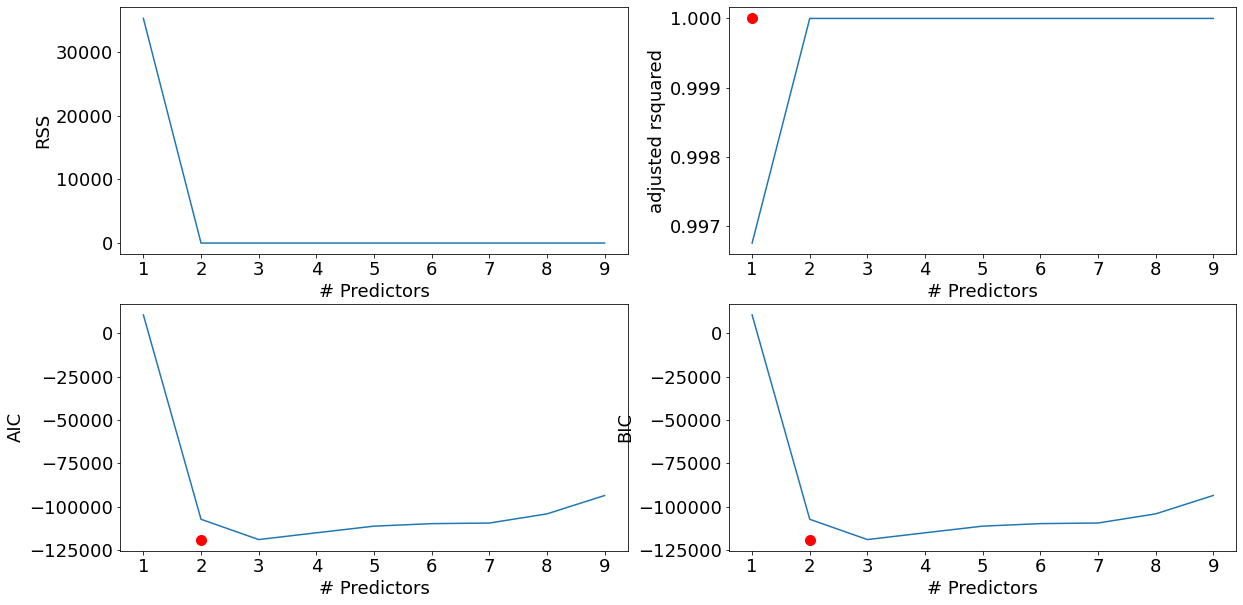

In [231]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

print(models_best.loc[models_best['AIC'].argmin()])

### Model with lowest AIC value

In [232]:
print(models_best.loc[models_best['AIC'] == models_best['AIC'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.376e+36
Date:                Tue, 04 May 2021   Prob (F-statistic):                        0.00
Time:                        21:55:42   Log-Likelihood:                          59500.
No. Observations:                1808   AIC:                                 -1.190e+05
Df Residuals:                    1805   BIC:                                 -1.190e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Model with lowest BIC value

In [233]:
print(models_best.loc[models_best['BIC'] == models_best['BIC'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.376e+36
Date:                Tue, 04 May 2021   Prob (F-statistic):                        0.00
Time:                        21:55:49   Log-Likelihood:                          59500.
No. Observations:                1808   AIC:                                 -1.190e+05
Df Residuals:                    1805   BIC:                                 -1.190e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Model with lowest RSS value

In [178]:
print(models_best.loc[models_best['RSS'] == models_best['RSS'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.376e+36
Date:                Tue, 04 May 2021   Prob (F-statistic):                        0.00
Time:                        21:36:50   Log-Likelihood:                          59500.
No. Observations:                1808   AIC:                                 -1.190e+05
Df Residuals:                    1805   BIC:                                 -1.190e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Forward stepwise regression

In [237]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]

    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    df = models[models['AIC'] == models['AIC'].min()]

    best_model = df.iloc[0]

    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [238]:
models_fwd = pd.DataFrame(columns=["RSS", "model", "AIC", "BIC", "features"])

predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names


Processed  9 models on 1 predictors
Processed  8 models on 2 predictors
Processed  7 models on 3 predictors
Processed  6 models on 4 predictors
Processed  5 models on 5 predictors
Processed  4 models on 6 predictors
Processed  3 models on 7 predictors
Processed  2 models on 8 predictors
Processed  1 models on 9 predictors


In [239]:
print(models_fwd.loc[models_fwd['AIC'] == models_fwd['AIC'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.376e+36
Date:                Tue, 04 May 2021   Prob (F-statistic):                        0.00
Time:                        22:05:16   Log-Likelihood:                          59500.
No. Observations:                1808   AIC:                                 -1.190e+05
Df Residuals:                    1805   BIC:                                 -1.190e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [240]:
print(models_fwd.loc[models_fwd['BIC'] == models_fwd['BIC'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.376e+36
Date:                Tue, 04 May 2021   Prob (F-statistic):                        0.00
Time:                        22:05:38   Log-Likelihood:                          59500.
No. Observations:                1808   AIC:                                 -1.190e+05
Df Residuals:                    1805   BIC:                                 -1.190e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [242]:
print(models_fwd.loc[models_fwd['RSS'] == models_fwd['RSS'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.376e+36
Date:                Tue, 04 May 2021   Prob (F-statistic):                        0.00
Time:                        22:06:00   Log-Likelihood:                          59500.
No. Observations:                1808   AIC:                                 -1.190e+05
Df Residuals:                    1805   BIC:                                 -1.190e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Backward Stepwise Regression

In [246]:
def backward(predictors):

    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    df = models[models['AIC'] == models['AIC'].min()]

    best_model = df.iloc[0]
    
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [250]:
models_bwd = pd.DataFrame(columns=["RSS", "model", "AIC", "BIC", "features"], index = range(1,len(X.columns)))

predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names


Processed  9 models on 8 predictors
Processed  8 models on 7 predictors
Processed  7 models on 6 predictors
Processed  6 models on 5 predictors
Processed  5 models on 4 predictors
Processed  4 models on 3 predictors
Processed  3 models on 2 predictors
Processed  2 models on 1 predictors


In [251]:
print(models_bwd.loc[models_bwd['AIC'] == models_bwd['AIC'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.187e+35
Date:                Tue, 04 May 2021   Prob (F-statistic):                        0.00
Time:                        22:09:09   Log-Likelihood:                          57930.
No. Observations:                1808   AIC:                                 -1.159e+05
Df Residuals:                    1805   BIC:                                 -1.158e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [252]:
print(models_bwd.loc[models_bwd['BIC'] == models_bwd['BIC'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.187e+35
Date:                Tue, 04 May 2021   Prob (F-statistic):                        0.00
Time:                        22:09:21   Log-Likelihood:                          57930.
No. Observations:                1808   AIC:                                 -1.159e+05
Df Residuals:                    1805   BIC:                                 -1.158e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [253]:
print(models_bwd.loc[models_bwd['RSS'] == models_bwd['RSS'].min()]["model"].tolist()[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.187e+35
Date:                Tue, 04 May 2021   Prob (F-statistic):                        0.00
Time:                        22:09:52   Log-Likelihood:                          57930.
No. Observations:                1808   AIC:                                 -1.159e+05
Df Residuals:                    1805   BIC:                                 -1.158e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### The features giving lowest AIC, BIC and RSS values Backward regression are upperLimit, upperError and year and the features giving lowest AIC, BIC and RSS values for best subset selection and Forward are upperLimit, upperError and lowerError

#### Fitting a model with all these features

In [254]:
X = data[["year", "lowerError", "upperLimit", "upperError"]]

In [255]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [256]:
model = sm.OLS(y_train, X_train).fit()
y_pred = model.predict(X_test)

In [257]:
print("MSE", mean_squared_error(y_test, y_pred))  

MSE 3.420605485379331e-28


In [259]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.504e+33
Date:                Tue, 04 May 2021   Prob (F-statistic):                        0.00
Time:                        22:11:50   Log-Likelihood:                          38200.
No. Observations:                1265   AIC:                                 -7.639e+04
Df Residuals:                    1261   BIC:                                 -7.637e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------